In [ ]:
# %%writefile weight_conv_vanilla.py
import safetensors
import torch
from torch import nn
from torch.nn import functional as F
import json
import os
import glob

from collections import defaultdict
from tqdm import tqdm
from sparseopt.attns.act_sparse_nbits import MFSparseNbits, QuantTool
from sparseopt.compress.compress_model import CompressOPT
from sparseopt.compress.compress_linear import CompressedLinear
from sparseopt.compress.compress_config import CompressConfig, LinearConfig, SparseQuantizeConfig

from einops import rearrange
from transformers.models.deepseek_v3.modeling_deepseek_v3 import DeepseekV3ForCausalLM, DeepseekV3DecoderLayer
from transformers import AutoTokenizer, AutoModelForCausalLM, DynamicCache
from transformers.integrations.finegrained_fp8 import FP8Linear
from datasets import load_dataset, load_from_disk
import typing
from typing import Optional, Union, List, Tuple, Dict, Mapping, Any, Callable
import copy
import shutil
from functools import partial
from collections import OrderedDict
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["HF_DATASETS_OFFLINE"] = "1"

Writing weight_conv_vanilla.py


In [ ]:
# %%writefile weight_conv_vanilla.py -a
in_weight_dir = "/ssd01/models/DeepSeek-V3.1-Terminus"
out_weight_dir = "/ssd01/models/DeepSeek-V3.1-Terminus-MF-Int8"
in_weight_dir = "/ssd01/models/DeepSeek-V3.2-Exp"
out_weight_dir = "/ssd01/models/DeepSeek-V3.2-Exp-MF-Int8"
index_file = os.path.join(in_weight_dir, "model.safetensors.index.json")

Appending to weight_conv_vanilla.py


In [ ]:
# %%writefile weight_conv_vanilla.py -a
with open(index_file) as f:
    weight_map = json.load(f)["weight_map"]
weight_map_ref = defaultdict(list)
for w, fpath in weight_map.items():
    weight_map_ref[fpath].append(w)
for fpath, w_list in weight_map_ref.items():
    print(f"{fpath}: {len(w_list)}")

Appending to weight_conv_vanilla.py


In [ ]:
# %%writefile weight_conv_vanilla.py -a
# vanilla version
tool = QuantTool(
    bank_size=64,
    mode="per_bank",
    dtype="int8",
    symmetric=True
)
w_block = [128, 128]

weights = defaultdict(dict)
def get_tensor(name):
    return weights[weight_map[name]][name]

def set_tensor(name, tensor):
    weights[weight_map[name]][name] = tensor

for fpath, w_list in tqdm(weight_map_ref.items(), desc="Loading weights"):
    in_file = os.path.join(in_weight_dir, fpath)
    with safetensors.safe_open(in_file, framework="pt", device="cpu") as f:
        for w_name in w_list:
            weights[fpath][w_name] = f.get_tensor(w_name)

for name in tqdm(list(weight_map.keys())[:], desc="Processing weights"):
    if name.endswith(".weight_scale_inv"):
        s_name = name
        w_name = name.replace(".weight_scale_inv", ".weight")
        
        scale = get_tensor(s_name)
        weight = get_tensor(w_name)
        w_shape = weight.shape
        
        scale = scale.repeat_interleave(w_block[0], dim=0)
        scale = scale.repeat_interleave(w_block[1], dim=1)
        weight = weight.to(scale.dtype) * \
            scale[:weight.size(0), :weight.size(1)]

        weight_ori = weight

        # quantize: int8 weight + bfloat16 scale
        weight = tool.transform.preprocess(weight)
        weight, scale = tool.sym_quant(weight)
        weight = tool.transform.postprocess(weight).to(torch.int8)
        scale = tool.transform.postprocess(scale).to(torch.bfloat16)
        # tqdm.write(w_name, weight.dtype, weight.shape, scale.dtype, scale.shape)

        weight_new = weight.to(torch.bfloat16) * scale.repeat_interleave(64, dim=-1)
        weight_ori = weight_ori.view(-1)
        weight_new = weight_new.view(-1)
        # diff = ((weight_new - weight_ori).abs() / weight_ori.abs())
        diff = (weight_new - weight_ori).abs()
        diff[weight_ori == 0] = 0
        value, index = diff.max(dim=0)
        value_ori = weight_ori[index]
        value_new = weight_new[index]
        tqdm.write(f"{w_name}: {value, value_ori, value_new}")

        # update weights
        set_tensor(s_name, scale)
        set_tensor(w_name, weight)

for fpath, w_dict in tqdm(weights.items(), desc="Saving weights"):
    out_file = os.path.join(out_weight_dir, fpath)
    safetensors.torch.save_file(weights[fpath], out_file)
    tqdm.write(f"Saved {len(w_dict)} weights to {out_file}")
file_list = [
    "configuration.json",
    "configuration_deepseek.py",
    "generation_config.json",
    "tokenizer_config.json",
    "tokenizer.json",
    "modeling_deepseek.py",
    "inference",
    "config.json",
    "model.safetensors.index.json"
]
for filepath in file_list:
    if os.path.exists(os.path.join(out_weight_dir, filepath)):
        if os.path.isdir(os.path.join(in_weight_dir, filepath)):
            shutil.copytree(
                os.path.join(in_weight_dir, filepath),
                os.path.join(out_weight_dir, filepath),
                dirs_exist_ok=True
            )
        elif filepath == "config.json":
            with open(os.path.join(out_weight_dir, filepath), mode="w") as ofid, \
                    open(os.path.join(in_weight_dir, filepath), mode="r") as ifid:
                info = json.load(ifid)
                info["quantization_config"] = {
                    "activation_scheme": "dynamic",
                    "mf_format": True,
                    "quant_method": "blockwise_int8",
                    "smooth": False,
                    "w_sparsity": 0,
                    "w_low_bits": 0,
                    "mask_in_id": False,
                    "weight_block_size": [
                        1,
                        64
                    ]
                }
                json.dump(info, ofid, indent=2, ensure_ascii=True)
        else:
            shutil.copy(
                os.path.join(in_weight_dir, filepath),
                os.path.join(out_weight_dir, filepath)
            )

Appending to weight_conv_vanilla.py


In [15]:
# smooth scale version
tool = QuantTool(
    bank_size=64,
    mode="per_bank",
    dtype="int8",
    symmetric=True
)
w_block = [128, 128]

weights = defaultdict(dict)
def get_tensor(name):
    return weights[weight_map[name]][name]

def set_tensor(name, tensor):
    weights[weight_map[name]][name] = tensor

for fpath, w_list in tqdm(weight_map_ref.items(), desc="Loading weights"):
    in_file = os.path.join(in_weight_dir, fpath)
    with safetensors.safe_open(in_file, framework="pt", device="cpu") as f:
        for w_name in w_list:
            weights[fpath][w_name] = f.get_tensor(w_name)

for name in tqdm(list(weight_map.keys())[:20], desc="Processing weights"):
    if name.endswith(".weight_scale_inv"):
        s_name = name
        w_name = name.replace(".weight_scale_inv", ".weight")
        
        scale = get_tensor(s_name)
        weight = get_tensor(w_name)
        w_shape = weight.shape
        
        scale = scale.repeat_interleave(w_block[0], dim=0)
        scale = scale.repeat_interleave(w_block[1], dim=1)
        weight = weight.to(scale.dtype) * \
            scale[:weight.size(0), :weight.size(1)]

        weight_ori = weight

        ###### smooth start ######
        compress_config = CompressConfig(
            general_linear=LinearConfig(
                inputs=SparseQuantizeConfig(
                    sparsity=0,
                    quantize=True,
                    high_bits=8,
                    low_bits=0,
                    bank_size=64,
                    group_size=64,
                    quant_method="per_bank",
                    kv_prefill_compress=False,
                    quant_symmetric=True,
                    fp8=False
                ),
                weights=SparseQuantizeConfig(
                    sparsity=0,
                    quantize=True,
                    high_bits=8,
                    low_bits=0,
                    bank_size=64,
                    group_size=64,
                    quant_method="per_bank",
                    kv_prefill_compress=False,
                    quant_symmetric=True,
                    fp8=False
                ),
                outputs=SparseQuantizeConfig(
                    sparsity=0,
                    quantize=False,
                    high_bits=8,
                    low_bits=0,
                    bank_size=64,
                    group_size=64,
                    quant_method="per_bank",
                    kv_prefill_compress=False,
                    quant_symmetric=True,
                    fp8=False
                ),
                smooth=True,
                num_grids=20
            )
        )
        compressed_linear = CompressedLinear(
            in_features=weight.size(1),
            out_features=weight.size(0),
            bias=False,
            compress_cfg=compress_config.general_linear
        )
        compressed_linear.weight.data.copy_(weight)
        compressopt = CompressOPT(
            module=compressed_linear,
            compress_cfg=compress_config.general_linear
        )

        inp = torch.randn(
            128, weight.size(1),
            dtype=torch.bfloat16, device=compressed_linear.weight.device
        )
        compressopt.add_batch(inp=inp, out=None)
        compressopt.smooth()
        weight = compressed_linear.weight
        smooth_scale = compressed_linear.smooth_scale
        # print(smooth_scale.shape, smooth_scale.dtype, smooth_scale)
        ###### smooth end ######
        
        # quantize: int8 weight + bfloat16 scale
        weight = tool.transform.preprocess(weight)
        weight, scale = tool.sym_quant(weight)
        weight = tool.transform.postprocess(weight).to(torch.int8)
        scale = tool.transform.postprocess(scale).to(torch.bfloat16)
        # tqdm.write(w_name, weight.dtype, weight.shape, scale.dtype, scale.shape)

        weight_new = weight.to(torch.bfloat16) * scale.repeat_interleave(64, dim=-1)
        weight_ori = weight_ori.view(-1)
        weight_new = weight_new.view(-1)
        # diff = ((weight_new - weight_ori).abs() / weight_ori.abs())
        diff = (weight_new - weight_ori).abs()
        diff[weight_ori == 0] = 0
        value, index = diff.max(dim=0)
        value_ori = weight_ori[index]
        value_new = weight_new[index]
        tqdm.write(f"{w_name}: {value, value_ori, value_new}")

        # update weights
        # set_tensor(s_name, scale)
        # set_tensor(w_name, weight)

# for fpath, w_dict in tqdm(weights.items(), desc="Saving weights"):
#     out_file = os.path.join(out_weight_dir, fpath)
#     safetensors.torch.save_file(weights[fpath], out_file)
    # tqdm.write(f"Saved {len(w_list)} weights to {out_file}")

Processing weights:   0%|          | 0/20 [00:00<?, ?it/s]

Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]


Processing weights:  15%|█▌        | 3/20 [00:01<00:10,  1.70it/s]

Best ratio: 0.050000000000000044, error: 1056768.0
Finish smoothing
torch.Size([1, 7168]) torch.bfloat16 tensor([[1.0469, 1.0547, 1.0625,  ..., 1.0469, 1.0547, 1.0469]],
       dtype=torch.bfloat16)
model.layers.0.self_attn.q_a_proj.weight: (tensor(0.0117), tensor(-0.2188), tensor(-0.2305, dtype=torch.bfloat16))
Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]


Processing weights:  30%|███       | 6/20 [00:02<00:06,  2.08it/s]

Best ratio: 0.050000000000000044, error: 176128.0
Finish smoothing
torch.Size([1, 1536]) torch.bfloat16 tensor([[1.0469, 1.0469, 1.0469,  ..., 1.0469, 1.0469, 1.0391]],
       dtype=torch.bfloat16)
model.layers.0.self_attn.q_b_proj.weight: (tensor(0.0703), tensor(1.1250), tensor(1.1953, dtype=torch.bfloat16))
Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]


Processing weights:  40%|████      | 8/20 [00:03<00:05,  2.11it/s]

Best ratio: 0.050000000000000044, error: 630784.0
Finish smoothing
torch.Size([1, 7168]) torch.bfloat16 tensor([[1.0547, 1.0547, 1.0625,  ..., 1.0547, 1.0547, 1.0469]],
       dtype=torch.bfloat16)
model.layers.0.self_attn.kv_a_proj_with_mqa.weight: (tensor(0.0430), tensor(0.8125), tensor(0.8555, dtype=torch.bfloat16))
Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]


Processing weights:  55%|█████▌    | 11/20 [00:04<00:02,  3.16it/s]

Best ratio: 0.050000000000000044, error: 28544.0
Finish smoothing
torch.Size([1, 512]) torch.bfloat16 tensor([[1.0469, 1.0469, 1.0469, 1.0469, 1.0469, 1.0391, 1.0469, 1.0469, 1.0469,
         1.0547, 1.0625, 1.0469, 1.0547, 1.0547, 1.0547, 1.0547, 1.0469, 1.0469,
         1.0469, 1.0547, 1.0469, 1.0547, 1.0547, 1.0469, 1.0469, 1.0625, 1.0547,
         1.0547, 1.0469, 1.0547, 1.0547, 1.0547, 1.0469, 1.0547, 1.0547, 1.0469,
         1.0469, 1.0469, 1.0469, 1.0469, 1.0469, 1.0547, 1.0547, 1.0391, 1.0391,
         1.0547, 1.0469, 1.0547, 1.0469, 1.0547, 1.0469, 1.0391, 1.0469, 1.0391,
         1.0469, 1.0391, 1.0469, 1.0547, 1.0547, 1.0547, 1.0547, 1.0547, 1.0469,
         1.0469, 1.0547, 1.0547, 1.0547, 1.0391, 1.0547, 1.0625, 1.0547, 1.0547,
         1.0469, 1.0391, 1.0469, 1.0469, 1.0469, 1.0547, 1.0547, 1.0469, 1.0469,
         1.0547, 1.0469, 1.0469, 1.0547, 1.0547, 1.0469, 1.0469, 1.0469, 1.0547,
         1.0547, 1.0469, 1.0469, 1.0469, 1.0625, 1.0469, 1.0547, 1.0547, 1.0547,
       

Processing weights:  65%|██████▌   | 13/20 [00:17<00:15,  2.21s/it]

model.layers.0.self_attn.o_proj.weight: (tensor(0.0026), tensor(0.4134), tensor(0.4160, dtype=torch.bfloat16))
Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
Best ratio: 1.0, error: 2490368.0
Finish smoothing
torch.Size([1, 7168]) torch.bfloat16 tensor([[2.6719, 3.0156, 2.4844,  ..., 2.9531, 2.8594, 2.6250]],
       dtype=torch.bfloat16)


Processing weights:  75%|███████▌  | 15/20 [00:24<00:12,  2.58s/it]

model.layers.0.mlp.gate_proj.weight: (tensor(0.7266), tensor(0.3125), tensor(1.0391, dtype=torch.bfloat16))
Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
Best ratio: 0.050000000000000044, error: 493568.0
Finish smoothing
torch.Size([1, 7168]) torch.bfloat16 tensor([[1.0391, 1.0547, 1.0547,  ..., 1.0469, 1.0469, 1.0469]],
       dtype=torch.bfloat16)


Processing weights:  85%|████████▌ | 17/20 [00:31<00:08,  2.84s/it]

model.layers.0.mlp.up_proj.weight: (tensor(0.0127), tensor(-0.2344), tensor(-0.2471, dtype=torch.bfloat16))
Smoothing ...
Searching best scale with ratio in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
Best ratio: 0.0, error: 1769472.0
Finish smoothing
torch.Size([1, 18432]) torch.bfloat16 tensor([[1., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.bfloat16)


Processing weights: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]

model.layers.0.mlp.down_proj.weight: (tensor(0.0024), tensor(0.0508), tensor(0.0532, dtype=torch.bfloat16))


In [9]:
# dump data
def disable_torch_init():
    """Disable initialization of Pytorch."""

    def skip(*args, **kwargs):
        pass

    torch.nn.init.normal_ = skip
    torch.nn.init.uniform_ = skip
    torch.nn.init.kaiming_uniform_ = skip

    DeepseekV3ForCausalLM._init_weights = skip

disable_torch_init()

In [ ]:

model_name_or_path = "/ssd01/models/DeepSeek-V3.1-Terminus"
model = DeepseekV3ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype="auto",
    device_map="auto"
)

In [3]:
model.model.layers[3].mlp

DeepseekV3MoE(
  (experts): ModuleList(
    (0-255): 256 x DeepseekV3MLP(
      (gate_proj): FP8Linear(in_features=7168, out_features=2048, bias=False)
      (up_proj): FP8Linear(in_features=7168, out_features=2048, bias=False)
      (down_proj): FP8Linear(in_features=2048, out_features=7168, bias=False)
      (act_fn): SiLUActivation()
    )
  )
  (gate): DeepseekV3TopkRouter()
  (shared_experts): DeepseekV3MLP(
    (gate_proj): FP8Linear(in_features=7168, out_features=2048, bias=False)
    (up_proj): FP8Linear(in_features=7168, out_features=2048, bias=False)
    (down_proj): FP8Linear(in_features=2048, out_features=7168, bias=False)
    (act_fn): SiLUActivation()
  )
)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
wiki_data = load_dataset(
    'wikitext', 'wikitext-2-raw-v1', split='test',
    # download_mode="reuse_dataset_if_exists"
)
wiki_enc = tokenizer("\n\n".join(wiki_data['text']), return_tensors='pt')

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /datasets/wikitext/resolve/main/README.md (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9e924bcd00>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 1f1e38a8-734b-49cc-b525-314f3a3d5702)')' thrown while requesting HEAD https://huggingface.co/datasets/wikitext/resolve/main/README.md
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /datasets/wikitext/resolve/main/README.md (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9e924be3e0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: df2fc62b-69b4-45bd-8732-629429f16570)')' thrown while requesting HEAD https://huggingface.co/datasets/wikitext/resolve/main/README.md
Retrying in 2s [Retry 2/5].
'(MaxRetryErro

In [10]:
# online quantization
# invalid: tensor is in meta format rather than data format
model_name_or_path = "/ssd01/models/DeepSeek-V3.1-Terminus"
cpu_model = DeepseekV3ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype="auto",
    device_map="cpu"
)

Loading checkpoint shards: 100%|██████████| 163/163 [00:24<00:00,  6.73it/s]
Some weights of the model checkpoint at /ssd01/models/DeepSeek-V3.1-Terminus were not used when initializing DeepseekV3ForCausalLM: ['model.layers.61.eh_proj.weight', 'model.layers.61.embed_tokens.weight', 'model.layers.61.enorm.weight', 'model.layers.61.hnorm.weight', 'model.layers.61.input_layernorm.weight', 'model.layers.61.mlp.experts.0.down_proj.weight', 'model.layers.61.mlp.experts.0.down_proj.weight_scale_inv', 'model.layers.61.mlp.experts.0.gate_proj.weight', 'model.layers.61.mlp.experts.0.gate_proj.weight_scale_inv', 'model.layers.61.mlp.experts.0.up_proj.weight', 'model.layers.61.mlp.experts.0.up_proj.weight_scale_inv', 'model.layers.61.mlp.experts.1.down_proj.weight', 'model.layers.61.mlp.experts.1.down_proj.weight_scale_inv', 'model.layers.61.mlp.experts.1.gate_proj.weight', 'model.layers.61.mlp.experts.1.gate_proj.weight_scale_inv', 'model.layers.61.mlp.experts.1.up_proj.weight', 'model.layers.61.

In [ ]:
wiki_enc["input_ids"].shape

torch.Size([1, 288925])

In [6]:
seqlen = 2048
input_ids = wiki_enc["input_ids"][:, :seqlen]
model(input_ids)


CausalLMOutputWithPast(loss=None, logits=tensor([[[ 0.2383, 10.8750,  1.1094,  ...,  0.9688,  1.0234,  1.1406],
         [ 8.5625,  6.4688, -0.0913,  ..., -0.1621, -0.1152, -0.0659],
         [ 3.7344, 14.8750,  5.1250,  ...,  5.1250,  5.2500,  5.1250],
         ...,
         [ 0.3926, 23.1250, -1.4922,  ..., -1.6406, -1.5312, -1.2734],
         [ 3.0469, 22.8750, -1.9297,  ..., -1.8828, -2.0312, -1.9766],
         [ 3.0312, 21.1250, -2.2656,  ..., -2.2812, -2.1719, -2.5625]]],
       dtype=torch.bfloat16, grad_fn=<ToCopyBackward0>), past_key_values=DynamicCache(layers=[DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, Dyn

In [ ]:
args_cache = []
kwargs_cache = []
def save_hook(
        module: nn.Module,
        args: tuple[torch.Tensor, ...],
        kwargs: dict[str, typing.Any],
        args_cache: list,
        kwargs_cache: list,
        raise_err: bool=False
    ) -> None:
        # for i in args:
        _list = []
        for item in args:
            if isinstance(item,torch.Tensor):
                _list.append(item.to('cpu'))
            else:
                _list.append(copy.deepcopy(item))
        args_cache.append(_list)
            
            
        _dict = {}
        for k,v in kwargs.items():
            if isinstance(v,torch.Tensor):
                _dict[k] = v.to('cpu')
            else:
                _dict[k] = copy.deepcopy(v)
                
        
        kwargs_cache.append(_dict)
        assert len(args_cache) == len(kwargs_cache)
        if raise_err:
            raise ValueError

# model.model.layers[0]._forward_pre_hooks = OrderedDict()
hook = model.model.layers[0].register_forward_pre_hook(
    partial(
        save_hook,
        args_cache=args_cache,
        kwargs_cache=kwargs_cache,
        raise_err=True
    ),
    # save_hook,
    with_kwargs=True
)

seqlen = 2048
input_ids = wiki_enc["input_ids"]
with torch.no_grad():
    for i in range(128):
        try:
                model(input_ids[:, i*seqlen: (i+1)*seqlen])
        except ValueError:
            pass
hook.remove()

In [15]:
# model.model.layers[0]._forward_pre_hooks = OrderedDict()
cache_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus/layer00"
os.makedirs(cache_dir, exist_ok=True)
torch.save(
    {'args': args_cache, 'kwargs': kwargs_cache},
    os.path.join(cache_dir, 'kiwi_cache.pt')
)
len(args_cache), len(kwargs_cache)

(128, 128)

In [ ]:
# 比较official和mf-int8-smooth差别
import torch
import os
official_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus/official-save"
mf_int8_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus/mf-int8-smooth-save"

In [1]:
import matplotlib.pyplot as plt
def compare(official, mf_int8):
    diff = (official - mf_int8).abs()
    # print(f"Max diff: {diff.max().item():.6f}")
    # print(f"Mean diff: {diff.mean().item():.6f}")
    # return diff
    return diff.max().item(), diff.mean().item()

mode = "prefill"
# mode = "decode"
max_diff_list = []
mean_diff_list = []
for layer in range(60):
    filename = f"layer{layer:02d}/{mode}-output.pt"
    official = torch.load(os.path.join(official_dir, filename))
    mf_int8 = torch.load(os.path.join(mf_int8_dir, filename))

    max_diff, mean_diff = compare(official, mf_int8)
    max_diff_list.append(max_diff)
    mean_diff_list.append(mean_diff)

figure = plt.figure(figsize=(10, 3))
ax = figure.add_subplot(1, 2, 1)
ax.plot(max_diff_list, label="max_diff")
plt.legend()
ax = figure.add_subplot(1, 2, 2)
ax.plot(mean_diff_list, label="mean_diff")
plt.legend()
plt.show()

NameError: name 'torch' is not defined

In [2]:
# 比较权重
import torch
import safetensors
import json
import os

def get_tensor(model_dir, name):
    with open(os.path.join(model_dir, "model.safetensors.index.json")) as fid:
        weight_map = json.load(fid)["weight_map"]
        filename = weight_map[name]
    with safetensors.safe_open(os.path.join(model_dir, filename), framework="pt") as m:
        return m.get_tensor(name)

layer_name = "model.layers.0.self_attn.q_a_proj"
layer_name = "model.layers.0.mlp.up_proj"
layer_name = "model.layers.0.mlp.gate_proj"
layer_name = "model.layers.3.mlp.experts.255.gate_proj"
layer_name = "model.layers.3.mlp.experts.255.up_proj"
# layer_name = "model.layers.3.mlp.shared_experts.gate_proj"
layer_name = "model.layers.3.mlp.shared_experts.up_proj"

model_dir = "/ssd01/models/DeepSeek-V3.1-Terminus/"
name = f"{layer_name}.weight"
fp8_weight = get_tensor(model_dir, name)
name = f"{layer_name}.weight_scale_inv"
fp8_scale = get_tensor(model_dir, name)
ori_weight = fp8_weight.to(fp8_scale.dtype) * fp8_scale.repeat_interleave(128, 1).repeat_interleave(128, 0)[:fp8_weight.size(0), :fp8_weight.size(1)]

# model_dir = "/ssd01/models/DeepSeek-V3.1-Terminus-MF-Int8-smooth/"
model_dir = "/ssd01/models/DeepSeek-V3.1-Terminus-MF-Int8/"

model_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus-model/"
# model_dir = "/ssd01/models/DeepSeek-V3.1-Terminus-MF-W8xH8L3/"
name = f"{layer_name}.smooth_scale"
try:
    smooth_scale = get_tensor(model_dir, name)
except:
    smooth_scale = 1

from sglang.srt.mf_tool import generate_mask
name = f"{layer_name}.mask"
try:
    mask = get_tensor(model_dir, name)
except:
    try:
        name = f"{layer_name}.mask_id"
        mask_id = get_tensor(model_dir, name)
        mask = generate_mask(mask_id, [1, 64], dtype=torch.int8)
    except:
        mask = 1

name = f"{layer_name}.weight"
int8_weight = get_tensor(model_dir, name)
name = f"{layer_name}.weight_scale_inv"
int8_scale = get_tensor(model_dir, name)

name = f"{layer_name}.lweight_scale_inv"
try:
    lint8_scale = get_tensor(model_dir, name)
except:
    lint8_scale = torch.ones_like(int8_scale)

new_weight = (
    int8_weight.to(int8_scale.dtype) * int8_scale.repeat_interleave(64, 1) * mask + \
    int8_weight.to(int8_scale.dtype) * lint8_scale.repeat_interleave(64, 1) * (1 - mask)
) / smooth_scale
(new_weight - ori_weight).abs().max(), (new_weight - ori_weight).abs().mean()

/ssd01/miniconda3/envs/sglang-v0.5.5.post3/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/ssd01/miniconda3/envs/sglang-v0.5.5.post3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor(0.0065), tensor(0.0012))

In [4]:
size = int(new_weight.size(0) // 16)
# mask_id[:int(size / 64)], lint8_scale[:size]
new_weight[:size, :], ori_weight[:size, :], mask[:size, :], 

(tensor([[ 0.0143,  0.0072, -0.0072,  ...,  0.0104, -0.0430,  0.0000],
         [ 0.0052,  0.0156, -0.0104,  ..., -0.0117, -0.0232,  0.0000],
         [-0.0117, -0.0059,  0.0000,  ...,  0.0000,  0.0137, -0.0045],
         ...,
         [ 0.0098, -0.0049,  0.0176,  ...,  0.0000, -0.0065, -0.0130],
         [-0.0078,  0.0039, -0.0039,  ...,  0.0000,  0.0127,  0.0085],
         [-0.0130,  0.0130, -0.0065,  ...,  0.0000,  0.0072,  0.0072]],
        dtype=torch.bfloat16),
 tensor([[ 0.0107,  0.0044, -0.0049,  ...,  0.0127, -0.0430, -0.0022],
         [ 0.0044,  0.0146, -0.0107,  ..., -0.0098, -0.0234, -0.0011],
         [-0.0098, -0.0078,  0.0016,  ..., -0.0011,  0.0137, -0.0037],
         ...,
         [ 0.0107, -0.0059,  0.0176,  ..., -0.0027, -0.0039, -0.0117],
         [-0.0063,  0.0044, -0.0049,  ..., -0.0012,  0.0107,  0.0073],
         [-0.0098,  0.0107, -0.0088,  ..., -0.0012,  0.0049,  0.0037]]),
 tensor([[0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 

In [3]:
mask_id

tensor([[[ 8, 20, 33,  ..., 47, 50, 51],
         [ 1, 14, 18,  ..., 37, 54, 57],
         [ 7, 26, 31,  ..., 47, 56, 60],
         ...,
         [ 6,  7,  8,  ..., 26, 38, 44],
         [ 0,  3, 12,  ..., 36, 53, 54],
         [ 2, 11, 19,  ..., 35, 60, 62]],

        [[18, 19, 24,  ..., 50, 56, 57],
         [16, 17, 18,  ..., 40, 47, 56],
         [ 3, 15, 24,  ..., 29, 55, 57],
         ...,
         [ 1,  4, 18,  ..., 50, 55, 58],
         [ 1, 13, 17,  ..., 24, 56, 57],
         [ 2,  7, 14,  ..., 54, 59, 62]],

        [[13, 17, 22,  ..., 52, 54, 56],
         [ 0,  9, 15,  ..., 36, 39, 44],
         [ 4, 16, 17,  ..., 33, 47, 50],
         ...,
         [12, 13, 16,  ..., 43, 55, 59],
         [ 0,  8, 16,  ..., 49, 51, 59],
         [ 4,  9, 16,  ..., 52, 59, 60]],

        ...,

        [[ 2,  7, 10,  ..., 33, 41, 56],
         [ 4, 19, 24,  ..., 46, 47, 58],
         [ 4, 14, 22,  ..., 34, 42, 47],
         ...,
         [ 0,  7,  8,  ..., 12, 26, 58],
         [ 4, 14, 18, 

In [1]:
# 比较dense / W8xH8L3 / Linear_WInt8-MOE_W8xH8L3

In [1]:
dense_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus/official-save"
w8xh8l3_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus/MF-W8xH8L3-save"
l_int8_moe_w8xh8l3_dir = "/ssd01/workspace/sglang-n/exp/data/DeepSeek-V3.1-Terminus/MF-Linear_WInt8-MOE_W8xH8L3-save"

layer00/prefill-attn-q_c: 0.011047, 0.078125
layer00/prefill-attn-q_b_proj: 0.009644, 1.250000
layer00/prefill-attn-kv_c: 0.011658, 0.125000
layer00/prefill-attn: 0.000083, 0.005188
layer00/prefill-o_proj: 0.000082, 0.005859
layer00/prefill-mlp: 0.000462, 0.054688
layer01/prefill-attn-q_c: 0.004730, 0.054688
layer01/prefill-attn-q_b_proj: 0.006195, 1.000000
layer01/prefill-attn-kv_c: 0.008911, 0.187500
layer01/prefill-attn: 0.000078, 0.003937
layer01/prefill-o_proj: 0.000182, 0.007324
layer01/prefill-mlp: 0.000385, 0.044922
layer02/prefill-attn-q_c: 0.006256, 0.087891
layer02/prefill-attn-q_b_proj: 0.013428, 0.796875
layer02/prefill-attn-kv_c: 0.009827, 0.187500
layer02/prefill-attn: 0.000056, 0.002167
layer02/prefill-o_proj: 0.000077, 0.001404
layer02/prefill-mlp: 0.000729, 0.046875
layer03/prefill-attn-q_c: 0.009155, 0.087891
layer03/prefill-attn-q_b_proj: 0.016235, 1.125000
layer03/prefill-attn-kv_c: 0.013184, 0.250000
layer03/prefill-attn: 0.000125, 0.007690
layer03/prefill-o_proj:

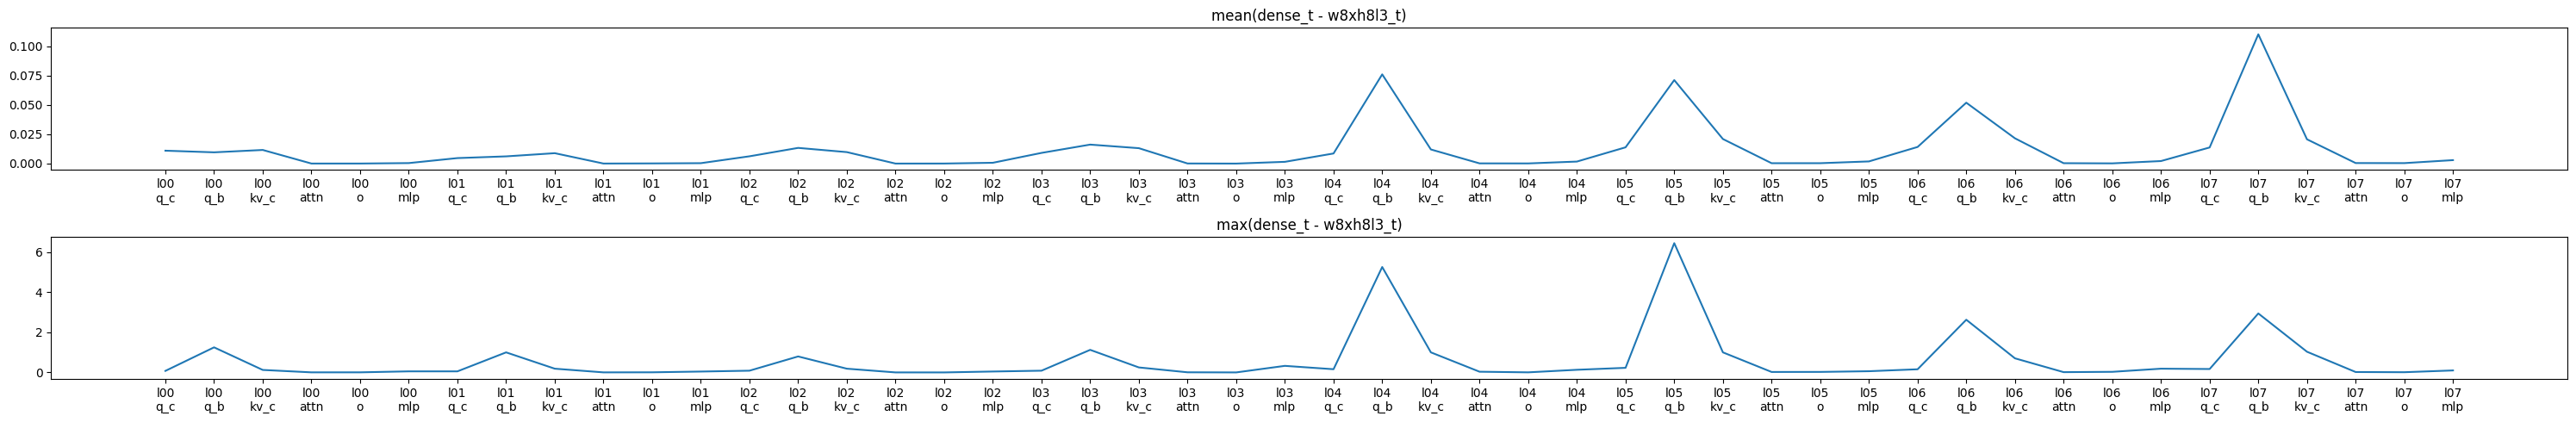

In [22]:
import torch
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import chain

def norm_key(key):
    return key.replace("layer", "l").replace("prefill-", "").replace("/", "\n").replace('attn-', '').replace("_proj", "")
        # .replace("output", "hidden")

keys = [
    [
        f"layer{i:02d}/prefill-attn-q_c",
        f"layer{i:02d}/prefill-attn-q_b_proj",
        f"layer{i:02d}/prefill-attn-kv_c",
        f"layer{i:02d}/prefill-attn",
        f"layer{i:02d}/prefill-o_proj",
        # f"layer{i:02d}/prefill-mlp-gate_up",
        # f"layer{i:02d}/prefill-mlp-down_proj",
        f"layer{i:02d}/prefill-mlp",
        # f"layer{i:02d}/prefill-output",
    ] for i in range(8)
]
keys = list(chain(*keys))
mean_list = []
max_list = []
for key in keys:
    dense_t = torch.load(os.path.join(dense_dir, f"{key}.pt"))
    w8xh8l3_t = torch.load(os.path.join(w8xh8l3_dir, f"{key}.pt"))
    # l_int8_moe_w8xh8l3_t = torch.load(os.path.join(l_int8_moe_w8xh8l3_dir, f"{key}.pt"))
    diff = (dense_t - w8xh8l3_t).abs()
    mean_list.append(diff.mean().item())
    max_list.append(diff.max().item())
    print(f"{key}: {diff.mean().item():.6f}, {diff.max().item():.6f}")

fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("mean(dense_t - w8xh8l3_t)")
ax.plot(mean_list)
ax.set_xticks(
    [i for i in range(len(keys))],
    [norm_key(key) for key in keys]
)
ax = fig.add_subplot(2, 1, 2)
ax.set_title("max(dense_t - w8xh8l3_t)")
ax.plot(max_list)
ax.set_xticks(
    [i for i in range(len(keys))],
    [norm_key(key) for key in keys]
)
plt.tight_layout()

In [6]:
diff

tensor([[7.0190e-04, 7.9346e-04, 1.9531e-03,  ..., 2.3193e-03, 1.4038e-03,
         5.1880e-04],
        [2.9755e-04, 4.5776e-04, 1.5259e-04,  ..., 1.5259e-05, 9.1553e-05,
         2.4414e-04],
        [4.4250e-04, 1.8311e-04, 6.2561e-04,  ..., 0.0000e+00, 8.3923e-05,
         4.5776e-05],
        ...,
        [1.6785e-04, 3.0518e-05, 4.2725e-04,  ..., 1.8311e-04, 2.5940e-04,
         0.0000e+00],
        [4.3106e-04, 5.1498e-04, 4.8828e-04,  ..., 3.0518e-05, 2.2888e-04,
         2.2888e-04],
        [3.8528e-04, 3.0518e-04, 4.2725e-04,  ..., 3.0518e-04, 0.0000e+00,
         1.5259e-05]], device='cuda:0', dtype=torch.bfloat16)